# (Self Study) Dimensionality Reduction

In this notebook, we will 

1. build our own PCA implementation,
1. review basic theory on kernel methods, and
1. implement Kernel PCA.

Key learnings:

1. Dimensionality reduction enables us to reduce the dimension of a feature set and to remove noise
1. Kernels can efficiently model complex, non-linear patterns in data

<br>

# Principal Component Analysis (PCA)

In [1]:
import common
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance
import seaborn as sns
import sklearn.datasets
import sklearn.decomposition
import statsmodels.stats.moment_helpers

## Generate data from a 2D MVN

In [2]:
np.random.seed(501)

cov = statsmodels.stats.moment_helpers.corr2cov(
    np.array([[1, 0.4], [0.4, 1]]), std=[1, 1]
)

X = np.random.multivariate_normal(mean=[1, 2], cov=cov, size=10_000)

## Scatterplot

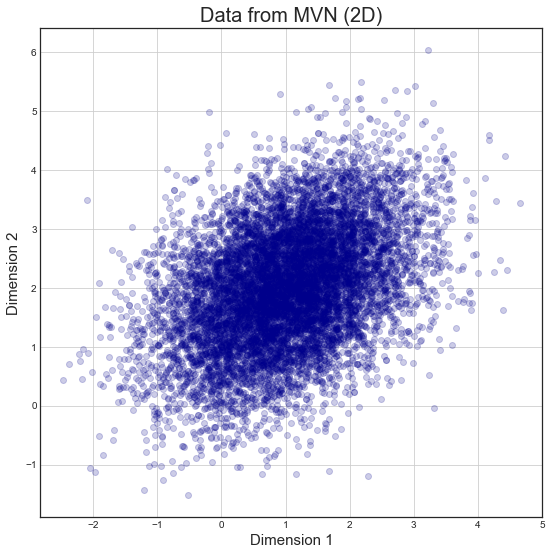

In [3]:
def my_scatter_plot(x):
    plt.scatter(x[:, 0], x[:, 1], alpha=0.2, c="darkblue")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title("Data from MVN (2D)")


my_scatter_plot(x=X)

## PCA with `sklearn`

In [4]:
pca_sklearn = sklearn.decomposition.PCA(n_components=2)
X_pca_sklearn = pca_sklearn.fit_transform(X)
X_pca_sklearn

array([[-0.11160003, -1.12803063],
       [-0.86358215,  0.96025498],
       [ 2.255998  , -0.39489394],
       ...,
       [ 1.04048792,  0.25194381],
       [-0.03594613, -0.38458348],
       [ 0.26234137, -0.15423921]])

### Looking at the components

In [5]:
# what are we doing here?
pca_sklearn.components_[:, 0].dot(pca_sklearn.components_[:, 1])

0.0

### Covariance matrices

We see that PCA finds an orthonormal basis in which the covariance matrix of the data has a diagonal form.

#### Reminder

Variance of $A=\{a,\dots,a_{N}\}$

$
\quad\sigma^2_A=\frac{1}{N}\sum_i (a_i - \bar{a})^2
$

Covariance of $A=\{a_1,\dots,a_{N}\}$ and $B=\{b_1,\dots,b_{N}\}$

$
\quad\sigma^2_{AB}=\frac{1}{N}\sum_i (a_i - \bar{a})(b_i - \bar{b})
$

with means $\bar a$ and $\bar b$.

#### Illustration of variance of 2D Gaussian along different directions of the space

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/pca-variance.gif" height="1200px">

[(Source)](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579#140579)

### With our data

In [6]:
# we know this one ...
np.corrcoef(X.T)

array([[1.        , 0.40125019],
       [0.40125019, 1.        ]])

In [7]:
X_pca_sklearn

array([[-0.11160003, -1.12803063],
       [-0.86358215,  0.96025498],
       [ 2.255998  , -0.39489394],
       ...,
       [ 1.04048792,  0.25194381],
       [-0.03594613, -0.38458348],
       [ 0.26234137, -0.15423921]])

In [8]:
# ... and this is what we expected
np.corrcoef(X_pca_sklearn.T).round(4)

array([[1., 0.],
       [0., 1.]])

### Data after projection

In [9]:
X_pca_sklearn.mean().round(2), X_pca_sklearn.std().round(2)

(0.0, 1.0)

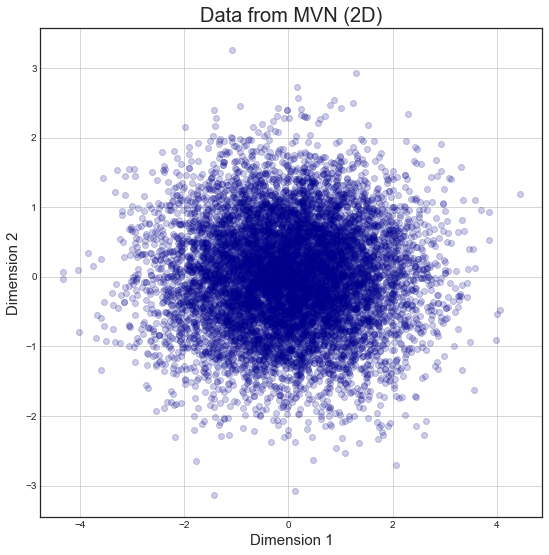

In [10]:
my_scatter_plot(x=X_pca_sklearn)

### Reconstruction

Reconstruct original data by

$
\quad X{^R} = X^{PCA} C + \mu
$

The (squared) difference between the original and the reconstructed data leads to the reconstruction error
 
$
\quad \big\| X - W C + \mu \big\|^{2}
$

PCA minimize the reconstruction error.

In [11]:
pca_sklearn.mean_

array([1.01204106, 2.00861934])

In [12]:
X_reconstructed = X_pca_sklearn.dot(pca_sklearn.components_) + pca_sklearn.mean_
X_reconstructed

array([[ 1.74677829,  1.14544561],
       [-0.27864628,  2.05322821],
       [ 2.86196458,  3.35889752],
       ...,
       [ 1.55271026,  2.9326148 ],
       [ 1.2639964 ,  1.71584795],
       [ 1.30515115,  2.09046803]])

In [13]:
assert np.max(np.abs(X - X_reconstructed)) < 1e-10

### Variance explained

In [14]:
pca_sklearn.explained_variance_ratio_

array([0.7007392, 0.2992608])

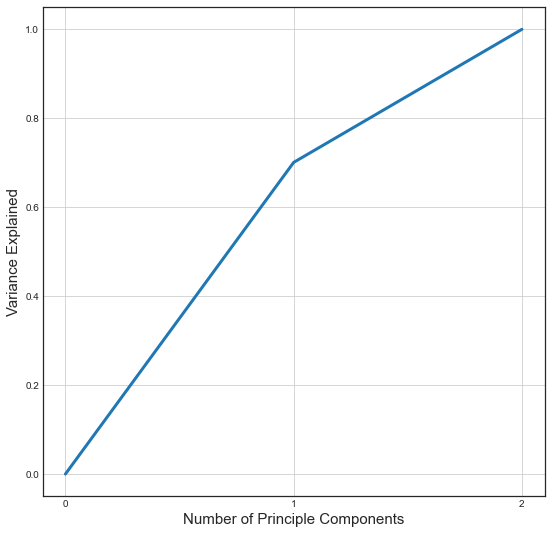

In [15]:
cumulative_explained_variance = np.cumsum(
    np.r_[[0], pca_sklearn.explained_variance_ratio_]
)
plt.plot(
    np.arange(len(cumulative_explained_variance)),
    cumulative_explained_variance,
    linewidth=3,
)
plt.xlabel("Number of Principle Components")
plt.ylabel("Variance Explained")
plt.xticks([0, 1, 2])
plt.show()

## Visualize Principal Components

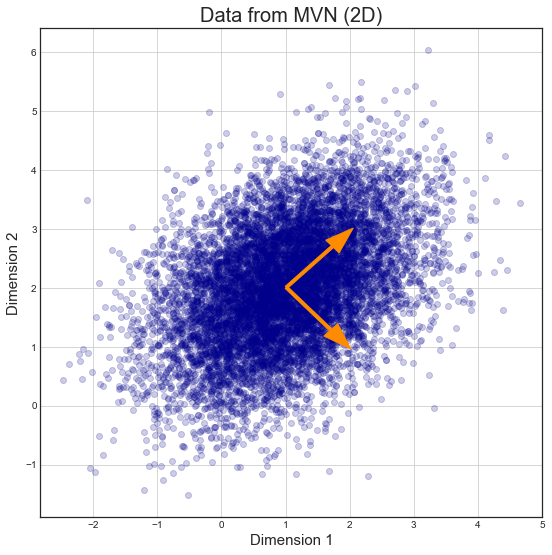

In [16]:
def my_arrow(x0, y0, dx, dy, scaling=1):
    plt.arrow(
        x0,
        y0,
        scaling * dx,
        scaling * dy,
        head_width=0.3,
        width=0.05,
        fc="darkorange",
        ec="darkorange",
    )


mean_X = X.mean(axis=0)

my_scatter_plot(x=X)
my_arrow(
    mean_X[0], mean_X[1], pca_sklearn.components_[0, 0], pca_sklearn.components_[1, 0]
)
my_arrow(
    mean_X[0], mean_X[1], pca_sklearn.components_[0, 1], pca_sklearn.components_[1, 1]
)
plt.show()

## Manual PCA

In [17]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, x):
        x_meaned = x - np.mean(x, axis=0)
        cov_mat = np.cov(x_meaned, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_mat)
        index = np.argsort(eigenvalues)[::-1]
        eigenvectors_subset = eigenvectors[:, index][:, 0 : self.n_components]
        x_reduced = x_meaned.dot(eigenvectors_subset)
        return x_reduced

In [18]:
pca = PCA(n_components=2)
X_pca = pca.fit(X)
X_pca

array([[-0.11160003, -1.12803063],
       [-0.86358215,  0.96025498],
       [ 2.255998  , -0.39489394],
       ...,
       [ 1.04048792,  0.25194381],
       [-0.03594613, -0.38458348],
       [ 0.26234137, -0.15423921]])

In [19]:
assert np.max(np.abs(X_pca - X_pca_sklearn)) < 1e-12

<br>
<br>

## Kernel Methods

### Motivation

How can we deal with non-linear relationships amount our data? We could map the data into a (possibly high dimensional) vector space in which relations between data are linear. This would allow us to use a linear algorithm in the new vector space.

Transform the feature space

$
\quad \{\phi(\mathbf x_1),\dots,\phi(\mathbf x_N)\},
$

where $\phi$ is a mapping function.

### Kernelization

Representing data in a high dimensional space can be computationally challenging. Instead of doing this, we use kernels.

A kernel $\mathcal K$ is a function that returns the dot product of the vectors in the feature space when applied to input vectors in the original space:

$
\quad \mathcal K(\mathbf x, \mathbf y) =  \big\langle \phi(\mathbf x), \phi(\mathbf y) \big\rangle
$

Certain algorithms only require the inner products between feature vectors (after applying $\phi$), so with kernels we do not need to embed the data into the space explicitly. We never need the coordinates of the data in the feature space!

### Example

Consider a simple Kernel function 

$
\quad \mathcal K(\mathbf x, \mathbf y) = (1 + \mathbf x\, \mathbf y)^2.
$

With $\mathbf x = (x_1, x_2)$ and $\phi(\mathbf x) = \left(1, x_1^2, x_2^2, \sqrt 2 x_1, \sqrt 2 x_2, \sqrt 2 x_1x_2 \right)$, it follows

$
\quad \mathcal K(\mathbf x, \mathbf y) \\
\quad\quad = (1 + \mathbf x\, \mathbf y)^2 \\
\quad\quad = (1 + x_1 y_1 + x_2 y_2 )^2 \\
\quad\quad = 1 + x_1^2 y_1^2 + x_2^2 y_2^2 + 2 x_1 y_1 + 2 x_2 y_2 + 2 x_1 y_1 x_2 y_2 \\
\quad\quad = \phi(\mathbf x)\, \phi(\mathbf y)
$

We see that the (polynomial) Kernel $\mathcal K(\mathbf x, \mathbf y) = (1 + \mathbf x\, \mathbf y)^2$ computes a dot product in a 6-dimensional space (without transforming the original data into six dimensions).

### Popular kernels

#### Linear kernel

Kernel with the identity feature mapping.

$
\quad \mathcal K (\mathbf x, \mathbf y) = \mathbf x\, \mathbf y + c
$

with $\mathbf x, \mathbf y \in \mathbb{R}^{d}$ and $c \geq 0$.

#### Polynomial kernels

Kernels of the form

$
\quad \mathcal K(\mathbf x, \mathbf y) = (c + \mathbf x\, \mathbf y)^n
$

with $\mathbf x, \mathbf y \in \mathbb{R}^{d}$, $c \geq 0$, and $n \geq 1$.

Compare example above and feature transformation in logistic regression in lecture 04 (concentric circles).


#### Gaussian kernels (aka Radial Basis Function):

Kernels resulting in nonlinear Gaussian distances of the original feature space

$
\quad \mathcal K(\mathbf x, \mathbf y) = \exp\left\{-\displaystyle\frac{1}{2\sigma^2} \big\| \mathbf x - \mathbf y \big\|_{2} \right\}
$

where $\mathbf x, \mathbf y \in \mathbb {R}^{d}$ and $\sigma > 0$.

_Note:_ Gaussian kernels can be viewed as an infinite sum over polynomial kernels.

#### String kernels

Kernels operating on strings. For example, measure similarity between two strings by counting number of sub-strings that occur in both strings.

### More background on the "Kernel trick"

See <br>
[[1] Jordan, Michael I., and Romain Thibaux. "The Kernel Trick." Lecture Notes. 2004. Web. 5 Jan. 2013.](http://www.cs.berkeley.edu/~jordan/courses/281B-spring04/lectures/lec3.pdf) <br>
[[2] Implicit Lifting and the Kernel Trick](http://gregorygundersen.com/blog/2019/12/10/kernel-trick/)

The gist:

> So instead of mapping our data via $\phi$ and computing the inner product, we can do it in one operation, leaving the mapping completely implicit. In fact in the end we don’t even need to know $\phi$, all we need to know is how to compute the modified inner product.  And because “modified inner product” is a long name, we will call it a kernel, $\mathcal K(\mathbf x, \mathbf y)$.

### Kernel methods and overfitting

Avoid overfitting by regularization and careful cross-validation.


## Kernel PCA

Compute Euclidean distances between points

$
\quad d_{ij} = \big\| x_i - x_j \big\|_{2}
$

Derive kernel matrix

$
\quad \kappa\big(x_i, x_j\big) = \exp\big\{ - \gamma \, d_{ij} \big\}
$

Center kernel matrix

$
\quad \quad \kappa \rightarrow \bar\kappa
$

Pick top N eigenvectors $e_i$ (scaled by $\sigma_i$)

$
\quad \quad \left\{ e_1,\, \ldots,\,  e_N \right\}
$


### Data

In [20]:
def scatterplot(x, title):
    plt.title(title)
    mask_1 = y == 1
    plt.scatter(x[~mask_1, 0], x[~mask_1, 1], c="darkblue", s=70, alpha=0.5)
    plt.scatter(x[mask_1, 0], x[mask_1, 1], c="darkorange", s=70, alpha=0.5)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.show()

In [21]:
np.random.seed(501)
X, y = sklearn.datasets.make_circles(n_samples=2_000, factor=0.2, noise=0.12)

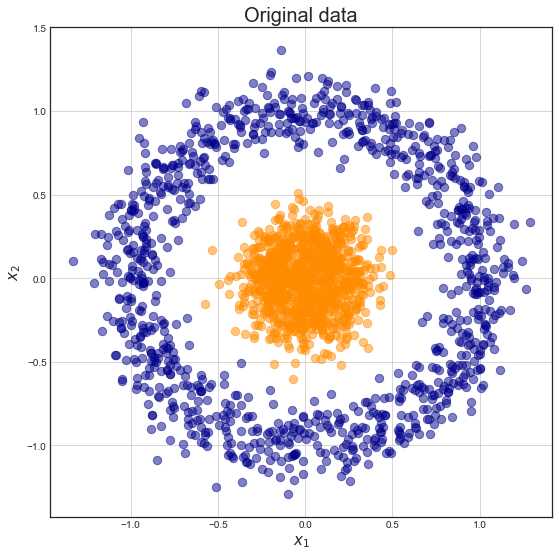

In [22]:
scatterplot(X, "Original data")

### Kernel PCA with `sklearn`

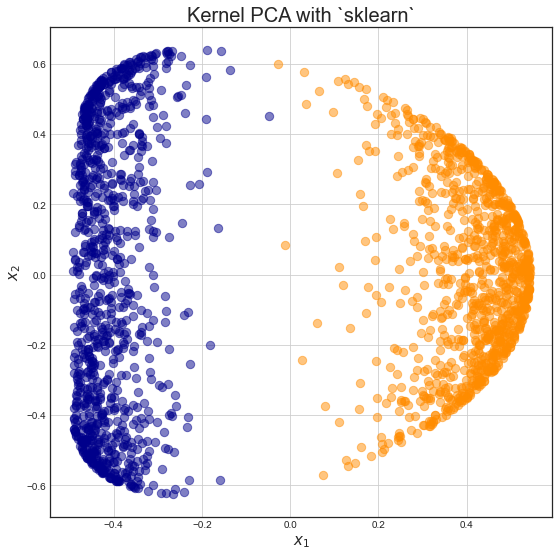

In [23]:
kpca_sklearn = sklearn.decomposition.KernelPCA(
    n_components=2,
    kernel="rbf",
    gamma=2,
)
X_kpca_sklearn = kpca_sklearn.fit_transform(X)
scatterplot(X_kpca_sklearn, "Kernel PCA with `sklearn`")

## Manual implementation of Kernel PCA

### Some first steps

In [24]:
gamma = 2
n_components = 2

In [25]:
# calculate squared Euclidean distances (yielding symmetric distance matrix)
distance_matrix = scipy.spatial.distance.squareform(
    scipy.spatial.distance.pdist(X, "sqeuclidean")
)
distance_matrix[:8, :8].round(3)

array([[0.   , 0.362, 1.553, 0.666, 0.281, 1.97 , 1.137, 1.663],
       [0.362, 0.   , 1.267, 0.429, 0.21 , 1.626, 0.854, 1.916],
       [1.553, 1.267, 0.   , 3.137, 0.571, 0.025, 0.041, 0.226],
       [0.666, 0.429, 3.137, 0.   , 1.093, 3.702, 2.462, 3.903],
       [0.281, 0.21 , 0.571, 1.093, 0.   , 0.836, 0.315, 0.877],
       [1.97 , 1.626, 0.025, 3.702, 0.836, 0.   , 0.127, 0.245],
       [1.137, 0.854, 0.041, 2.462, 0.315, 0.127, 0.   , 0.33 ],
       [1.663, 1.916, 0.226, 3.903, 0.877, 0.245, 0.33 , 0.   ]])

In [26]:
# compute kernel matrix
kappa = np.exp(-gamma * distance_matrix)

In [27]:
# center kernel matrix
kappa = sklearn.preprocessing.KernelCenterer().fit_transform(kappa)
np.abs(kappa.mean()), np.max(np.abs(kappa.mean(axis=0))), np.max(
    np.abs(kappa.mean(axis=1))
)

(1.4646062140855066e-18, 1.9031443088124433e-15, 1.0391687510491466e-16)

In [28]:
# compute eigenvectors
eigenvalues, eigenvectors = scipy.linalg.eigh(kappa)
eigenvalues

array([-5.04608048e-13, -1.59770834e-13, -9.77004940e-14, ...,
        2.09471787e+02,  2.15192435e+02,  3.46389665e+02])

In [29]:
# pick and return "top" `n_components` eigenvectors
# (i.e., eigenvectors with largest eigenvalues)
index = np.argsort(-eigenvalues)
eigenvectors[:, index][:, :n_components] * np.sqrt(eigenvalues[index][:n_components])

array([[ 0.2613215 ,  0.47466218],
       [ 0.19387207, -0.05731924],
       [-0.35350321, -0.54586729],
       ...,
       [-0.31544988,  0.61262087],
       [-0.32035229,  0.47988443],
       [ 0.48727352, -0.1235291 ]])

### Putting it all together

In [30]:
class KernelPCA:
    def __init__(self, n_components, gamma):
        self.n_components = n_components
        self.gamma = gamma

    def fit(self, x):
        # calculate squared Euclidean distances (yielding symmetric distance matrix)
        distance_matrix = scipy.spatial.distance.squareform(
            scipy.spatial.distance.pdist(x, "sqeuclidean")
        )

        # compute kernel matrix
        kappa = np.exp(-self.gamma * distance_matrix)

        # center kernel matrix
        kappa = sklearn.preprocessing.KernelCenterer().fit_transform(kappa)

        # compute eigenvectors
        eigenvalues, eigenvectors = scipy.linalg.eigh(kappa)

        # pick and return "top" `n_components` eigenvectors
        # (i.e., eigenvectors with largest eigenvalues)
        idx = [-i - 1 for i in range(self.n_components)]
        return eigenvectors[:, idx] * np.sqrt(eigenvalues[idx])

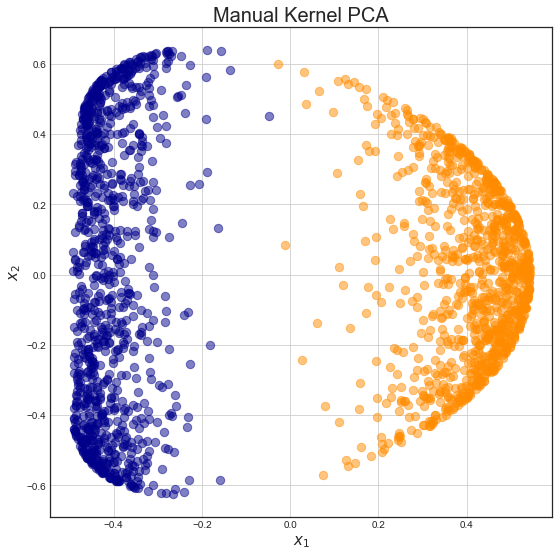

In [31]:
kernel_pca = KernelPCA(2, 2)
X_kpca = kernel_pca.fit(X)
scatterplot(X_kpca, "Manual Kernel PCA")

In [32]:
assert np.max(np.abs(X_kpca - X_kpca_sklearn)) < 1e-12

<br>
<br>
<b>Learning from Big Data</b> <br>
Sebastian Gabel <br>